In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class Node:
    def __init__(self, attribute=None, threshold=None, label=None, branches=None):
        self.attribute = attribute
        self.threshold = threshold
        self.label = label
        self.branches = branches or {}

def entropy(data, label_index):
    labels = [row[label_index] for row in data]
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def information_gain(data, attribute, label_index, criterion='info_gain'):
    total_entropy = entropy(data, label_index)
    weighted_entropy = 0
    
    if isinstance(data[0][attribute], (int, float)):
        values = [float(row[attribute]) for row in data if row[attribute] != 'unknown']
        threshold = np.median(values)
        left_subset = [row for row in data if row[attribute] != 'unknown' and float(row[attribute]) <= threshold]
        right_subset = [row for row in data if row[attribute] != 'unknown' and float(row[attribute]) > threshold]
        
        if left_subset:
            weighted_entropy += len(left_subset) / len(data) * entropy(left_subset, label_index)
        if right_subset:
            weighted_entropy += len(right_subset) / len(data) * entropy(right_subset, label_index)
    else:
        for value in set(row[attribute] for row in data if row[attribute] != 'unknown'):
            subset = [row for row in data if row[attribute] == value]
            weighted_entropy += len(subset) / len(data) * entropy(subset, label_index)
    
    return total_entropy - weighted_entropy

def choose_best_attribute(data, attributes, label_index, criterion='info_gain'):
    best_gain = -float('inf')
    best_attribute = None
    best_threshold = None
    
    for attribute in attributes:
        gain = information_gain(data, attribute, label_index, criterion)
        if gain > best_gain:
            best_gain = gain
            best_attribute = attribute
            if isinstance(data[0][attribute], (int, float)):
                values = [float(row[attribute]) for row in data if row[attribute] != 'unknown']
                best_threshold = np.median(values)
    
    return best_attribute, best_threshold

def id3(data, attributes, label_index, max_depth, criterion='info_gain'):
    labels = [row[label_index] for row in data]
    
    if not labels:
        return Node(label=None)
    
    if len(set(labels)) == 1:
        return Node(label=labels[0])
    
    if len(attributes) == 0 or (max_depth is not None and max_depth <= 0):
        return Node(label=max(set(labels), key=labels.count))
    
    best_attribute, threshold = choose_best_attribute(data, attributes, label_index, criterion)
    node = Node(attribute=best_attribute, threshold=threshold)
    
    if threshold is not None:
        left_subset = [row for row in data if row[best_attribute] != 'unknown' and float(row[best_attribute]) <= threshold]
        right_subset = [row for row in data if row[best_attribute] != 'unknown' and float(row[best_attribute]) > threshold]
        if left_subset:
            node.branches[f"<={threshold}"] = id3(left_subset, attributes, label_index, max_depth-1 if max_depth is not None else None, criterion)
        if right_subset:
            node.branches[f">{threshold}"] = id3(right_subset, attributes, label_index, max_depth-1 if max_depth is not None else None, criterion)
    else:
        for value in set(row[best_attribute] for row in data if row[best_attribute] != 'unknown'):
            subset = [row for row in data if row[best_attribute] == value]
            if subset:
                node.branches[value] = id3(subset, attributes, label_index, max_depth-1 if max_depth is not None else None, criterion)
    
    if not node.branches:
        return Node(label=max(set(labels), key=labels.count))
    
    return node

def predict(node, instance):
    if node.label is not None:
        return node.label
    if node.attribute >= len(instance):
        return None
    value = instance[node.attribute]
    if node.threshold is not None:
        if value == 'unknown':
            return None
        if float(value) <= node.threshold:
            branch = f"<={node.threshold}"
        else:
            branch = f">{node.threshold}"
    else:
        branch = value
    if branch not in node.branches:
        return None
    return predict(node.branches[branch], instance)

def bootstrap_sample(data):
    n_samples = len(data)
    return [data[np.random.randint(n_samples)] for _ in range(n_samples)]

def bagged_trees(data, n_trees, max_depth):
    label_index = len(data[0]) - 1
    attributes = list(range(len(data[0]) - 1))
    
    trees = []
    for _ in range(n_trees):
        sample = bootstrap_sample(data)
        tree = id3(sample, attributes, label_index, max_depth)
        trees.append(tree)
    
    return trees

def bagged_predict(trees, instance):
    predictions = [predict(tree, instance) for tree in trees]
    predictions = [p for p in predictions if p is not None]
    return max(set(predictions), key=predictions.count) if predictions else None

def load_data(filename):
    data = np.genfromtxt(filename, delimiter=',', dtype=str)
    return data.tolist()


Number of trees: 1
Train error: 0.0365
Test error: 0.1601

Number of trees: 5
Train error: 0.0188
Test error: 0.1808

Number of trees: 10
Train error: 0.0082
Test error: 0.1734

Number of trees: 20
Train error: 0.0028
Test error: 0.1752

Number of trees: 50
Train error: 0.0008
Test error: 0.1678

Number of trees: 100
Train error: 0.0000
Test error: 0.1698

Number of trees: 200
Train error: 0.0000
Test error: 0.1732

Number of trees: 500
Train error: 0.0000
Test error: 0.1653



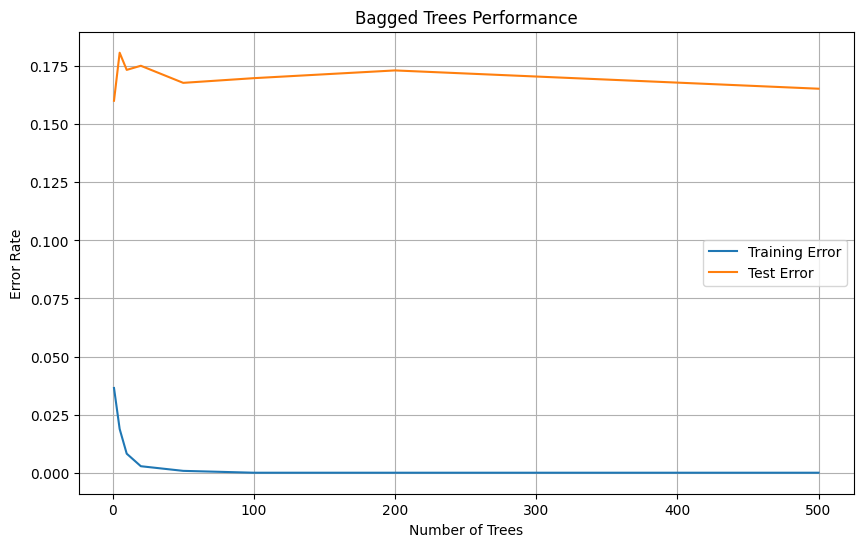

In [9]:
# Load and preprocess data
train_data = load_data('train_bank.csv')
test_data = load_data('test_bank.csv')

# Replace unknown values
for dataset in [train_data, test_data]:
    for attr in range(len(dataset[0]) - 1):
        known_values = [row[attr] for row in dataset if row[attr] != 'unknown']
        if known_values:
            majority = max(set(known_values), key=known_values.count)
            for row in dataset:
                if row[attr] == 'unknown':
                    row[attr] = majority

# Run Bagged Trees
T_values = [1, 5, 10, 20, 50, 100, 200, 500]
train_errors = []
test_errors = []

for T in T_values:
    trees = bagged_trees(train_data, T, max_depth=None)
    
    train_preds = [bagged_predict(trees, instance) for instance in train_data]
    test_preds = [bagged_predict(trees, instance) for instance in test_data]
    
    train_error = np.mean([pred != instance[-1] for pred, instance in zip(train_preds, train_data) if pred is not None])
    test_error = np.mean([pred != instance[-1] for pred, instance in zip(test_preds, test_data) if pred is not None])
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    print(f"Number of trees: {T}")
    print(f"Train error: {train_error:.4f}")
    print(f"Test error: {test_error:.4f}")
    print()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(T_values, train_errors, label='Training Error')
plt.plot(T_values, test_errors, label='Test Error')
plt.xlabel('Number of Trees')
plt.ylabel('Error Rate')
plt.title('Bagged Trees Performance')
plt.legend()
plt.grid(True)
plt.show()